# Support Vector Machines (SVM) Lab

**Course:** BINF 4211: Applied Data Mining for Bioinformatics

**Goals:**
- Learn how SVMs work (geometrically + practically),
- Learn how to train/evaluate them correctly for bioinformatics-style datasets (small *n*, large *d*).


## What you will do
1. Build intuition for the **maximum-margin** idea (linear SVM)
2. Train a linear SVM on a high-dimensional dataset
3. Train an RBF-kernel SVM and tune hyperparameters (**C** and **gamma**)
4. Evaluate with confusion matrix, ROC, PR curve
5. Learn best practices: scaling, leakage avoidance, and model selection


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.decomposition import PCA

np.random.seed(7)

## Part 1 — Create a bioinformatics-style dataset
Bioinformatics often looks like:
- **small n** (patients) and **large p** (genes/metabolites)
- noisy features
- correlated features
- mild class imbalance

We'll simulate something realistic.


In [11]:
X, y = make_classification(
    n_samples=120,          # small number of patients
    n_features=2000,        # large number of genes/features
    n_informative=40,
    n_redundant=40,
    n_repeated=0,
    n_classes=2,
    weights=[0.6, 0.4],
    class_sep=1.0,
    flip_y=0.03,
    random_state=7
)

print('X shape:', X.shape)
print('Class balance:', np.bincount(y))

X shape: (120, 2000)
Class balance: [72 48]


### Train/test split
We will hold out a test set. All hyperparameter tuning must happen on the training set only.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=7
)

print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (90, 2000)  Test: (30, 2000)


## Part 2 — Why scaling matters for SVM
SVMs are distance-based.

**If features are on different scales, the SVM boundary will be dominated by the largest-scale features.**

We’ll demonstrate by comparing:
- SVM without scaling
- SVM with scaling


In [4]:
from sklearn.metrics import accuracy_score

svm_no_scale = SVC(kernel='linear', C=1.0)
svm_no_scale.fit(X_train, y_train)
pred_no_scale = svm_no_scale.predict(X_test)

pipe_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])
pipe_scaled.fit(X_train, y_train)
pred_scaled = pipe_scaled.predict(X_test)

print('Accuracy (no scaling):', accuracy_score(y_test, pred_no_scale))
print('Accuracy (scaled):    ', accuracy_score(y_test, pred_scaled))

Accuracy (no scaling): 0.8
Accuracy (scaled):     0.6333333333333333


## Part 3 — Linear SVM: margin + support vectors
A linear SVM finds a hyperplane that separates classes while maximizing the margin.

### Key hyperparameter: **C**
- Small C → wider margin, more tolerance for errors (more regularization)
- Large C → narrower margin, tries to classify training points correctly (risk of overfitting)


### Cross-validation over C (linear SVM)
We'll do 5-fold CV on the training set.


In [6]:
C_grid = [0.01, 0.1, 1, 10, 100]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

scores = []
for C in C_grid:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=C))
    ])
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    scores.append((C, cv_scores.mean(), cv_scores.std()))

df_scores = pd.DataFrame(scores, columns=['C', 'mean_acc', 'std_acc'])
df_scores

,C,mean_acc,std_acc
0,0.01,0.588889,0.066667
1,0.10,0.588889,0.066667
2,1.00,0.588889,0.066667
3,10.00,0.588889,0.066667
4,100.00,0.588889,0.066667


### Plot CV accuracy vs C


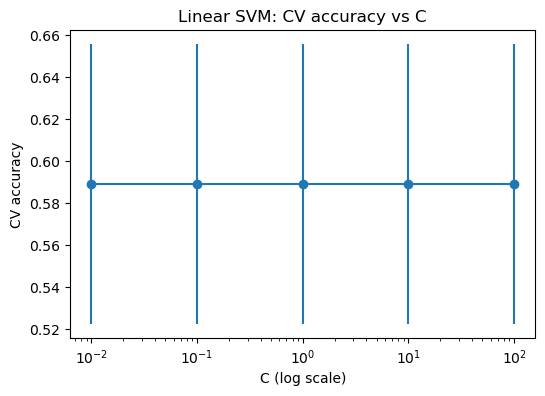

In [7]:
plt.figure(figsize=(6,4))
plt.errorbar(df_scores['C'], df_scores['mean_acc'], yerr=df_scores['std_acc'], fmt='o-')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('CV accuracy')
plt.title('Linear SVM: CV accuracy vs C')
plt.show()

### Train the best linear SVM and evaluate on test


Best C: 0.01
              precision    recall  f1-score   support

           0       0.64      0.89      0.74        18
           1       0.60      0.25      0.35        12

    accuracy                           0.63        30
   macro avg       0.62      0.57      0.55        30
weighted avg       0.62      0.63      0.59        30



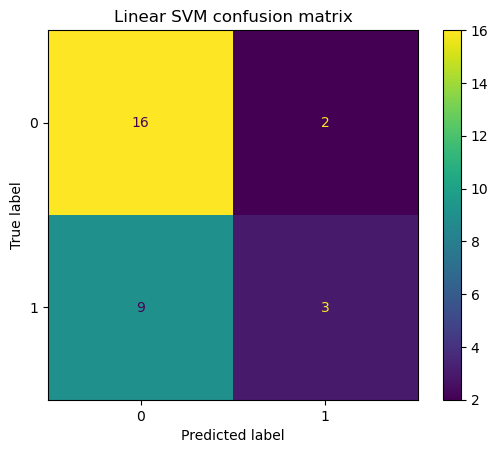

In [8]:
best_C = df_scores.loc[df_scores['mean_acc'].idxmax(), 'C']
print('Best C:', best_C)

best_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=best_C, probability=True))
])
best_linear.fit(X_train, y_train)

y_pred = best_linear.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Linear SVM confusion matrix')
plt.show()

## Part 4 — ROC curve and PR curve
In bioinformatics, **class imbalance is common**.

So we often report:
- ROC AUC
- PR AUC (Average Precision)


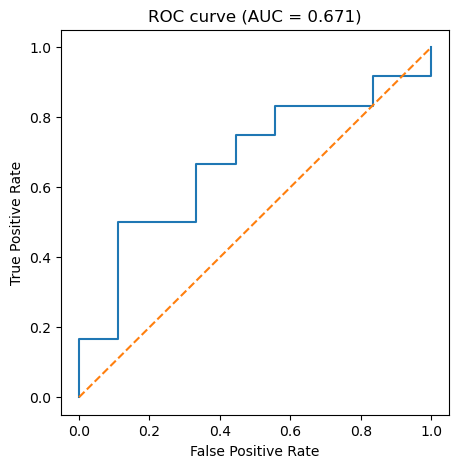

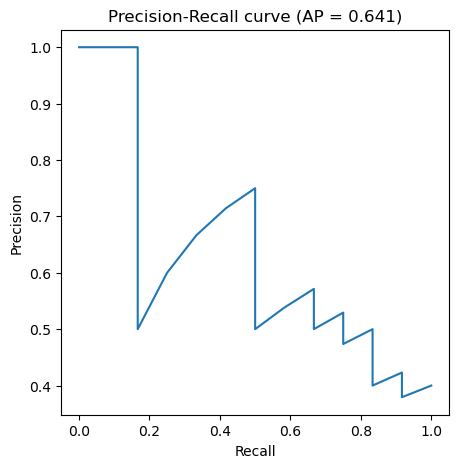

In [9]:
y_score = best_linear.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {roc_auc:.3f})')
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(5,5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.3f})')
plt.show()

## Part 5 — Nonlinear SVM with RBF kernel
When biology is nonlinear (very common), an RBF kernel can work well.

### Key hyperparameters
- **C**: penalty strength
- **gamma**: how local the decision boundary is
  - small gamma → smoother boundary
  - large gamma → very wiggly boundary (overfits)


### Grid search for RBF SVM
We'll tune (C, gamma) with 5-fold CV on the training set.


In [ ]:
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1e-4, 1e-3, 1e-2, 1e-1]
}

rbf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])

grid = GridSearchCV(
    rbf_pipe,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=7),
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
print('Best CV accuracy:', grid.best_score_)

### Evaluate best RBF SVM on test


In [ ]:
best_rbf = grid.best_estimator_
y_pred_rbf = best_rbf.predict(X_test)
print(classification_report(y_test, y_pred_rbf))

cm = confusion_matrix(y_test, y_pred_rbf)
ConfusionMatrixDisplay(cm).plot()
plt.title('RBF SVM confusion matrix')
plt.show()

## Part 6 — Visual intuition using PCA (2D projection)
With 2000 features, we cannot visualize the true hyperplane.

But we can project samples into 2D using PCA to see if the classes separate.


In [ ]:
pca = PCA(n_components=2, random_state=7)
X_train_2d = pca.fit_transform(StandardScaler().fit_transform(X_train))

plt.figure(figsize=(6,5))
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection of training data (colored by class)')
plt.show()

## Part 7 — Common bioinformatics best practices
### ✅ Do
- Always scale features
- Use a pipeline to prevent leakage
- Use cross-validation for hyperparameter tuning
- Report ROC + PR curves when classes are imbalanced

### ❌ Don't
- Tune hyperparameters on the test set
- Perform feature selection on the full dataset before CV
- Interpret SVM coefficients without thinking about scaling and collinearity


## Optional challenge
Try adding feature selection inside the pipeline:
- SelectKBest (t-test)
- then SVM

Compare performance for k = 50, 200, 500.


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

pipe_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=200)),
    ('svm', SVC(kernel='linear', C=1.0))
])

cv_scores = cross_val_score(pipe_fs, X_train, y_train, cv=5, scoring='accuracy')
print('CV accuracy with feature selection:', cv_scores.mean(), '+/-', cv_scores.std())